In [12]:
import pandas as pd

In [13]:
"dinov2-base-imagenet1k-1-layer_seed1.csv"
path = "/Users/chris/projects/Nature2023MooneyScripts/results/long_native_trials/"

dfs = []

for synth_seed in range(1000):
    for model_seed in range(4):
        file_csv = path + f"/{synth_seed}_dinov2-base-imagenet1k-1-layer_seed{model_seed}.csv"
        loaded = pd.read_csv(file_csv)
        loaded["model_seed"] = model_seed
        loaded["synth_seed"] = synth_seed

        dfs.append(loaded)

df = pd.concat(dfs)

In [14]:
df.head()

,Image phase,Time index,Ground truth class,Predicted class,model_seed,synth_seed
0,pre,0,5,33,0,0
1,pre,1,743,794,0,0
2,pre,2,511,511,0,0
3,gray,0,5,5,0,0
4,gray,1,743,743,0,0


In [15]:
from scipy.stats import norm
import numpy as np

def two_proportion_z_test(success_a, trials_a, success_b, trials_b, alternative='two-sided'):
    # Calculate success rates
    p1 = success_a / trials_a
    p2 = success_b / trials_b

    # Calculate pooled success rate
    pooled_p = (success_a + success_b) / (trials_a + trials_b)

    # Calculate standard error
    standard_error = np.sqrt(pooled_p * (1 - pooled_p) * (1 / trials_a + 1 / trials_b))

    # Calculate z-statistic
    z_stat = (p1 - p2) / standard_error

    # Calculate p-value based on the alternative hypothesis
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_stat)
    elif alternative == 'less':
        p_value = norm.cdf(z_stat)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    return z_stat, p_value

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df["Accuracy"] = (df["Ground truth class"] == df["Predicted class"]).astype(int)

## Compare single image performance

In [9]:
df.columns

Index(['synth_seed', 'model_seed', 'Image phase', 'Time index',
       'Ground truth class', 'Predicted class', 'Accuracy'],
      dtype='object')

In [25]:
first_df = df[df["Time index"] == 0]
first_df = first_df[first_df["Image phase"] != "repetition"]

# Get phase performance
first_perf = first_df.groupby("Image phase").agg({"Accuracy": "mean"}).reset_index()

In [24]:
first_perf

,Image phase,Accuracy
0,gray,0.85400
1,post,0.72875
2,pre,0.56150
3,repetition,0.58550


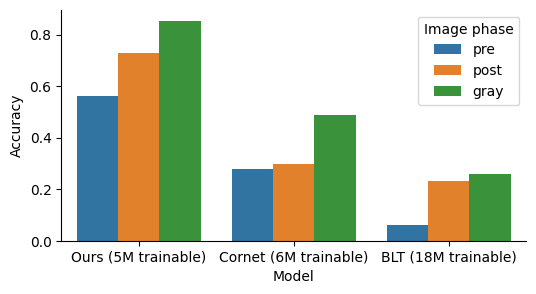

In [35]:
plt.figure(figsize=(6, 3))

perf_df = {
    "Model": ["Ours", "Ours", "Ours", "Cornet", "Cornet", "Cornet", "BLT", "BLT", "BLT"],
    "Accuracy": [0.85400, 0.72875, 0.56150, 0.48886, 0.29602, 0.27856, 0.26, 0.23, 0.06],
    "Image phase": ["gray", "post", "pre", "gray", "post", "pre", "gray", "post", "pre"]
}
perf_df = pd.DataFrame(perf_df)

# Append the number of trainable parameters
perf_df.replace({"Ours": "Ours (5M trainable)", "Cornet": "Cornet (6M trainable)", "BLT": "BLT (18M trainable)"}, inplace=True)

sns.barplot(data=perf_df, x="Model", y="Accuracy", hue="Image phase", hue_order=["pre", "post", "gray"])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.savefig("/Users/chris/Desktop/performance.png", dpi=1200, bbox_inches="tight")

In [ ]:
# Add the other models
other_model = {}

## Long performance

In [ ]:
# Average over a trial
df = df.groupby(["synth_seed", "model_seed", "Image phase"]).mean().reset_index()

In [8]:
from scipy.stats import mannwhitneyu, ttest_1samp

# Test if:
# 1. Repetition > pre
# 2. Post > pre
# 3. Post > repetition
# 4. Gray > post
# 5. Gray < 0.845

pre_acc = df[df["Image phase"] == "pre"]["Accuracy"]
post_acc = df[df["Image phase"] == "post"]["Accuracy"]
repetition_acc = df[df["Image phase"] == "repetition"]["Accuracy"]
gray_acc = df[df["Image phase"] == "gray"]["Accuracy"]

# 1. Repetition > pre
comp1 = mannwhitneyu(repetition_acc, pre_acc)

# 2. Post > pre
comp2 = mannwhitneyu(post_acc, pre_acc)

# 3. Post > repetition
comp3 = mannwhitneyu(post_acc, repetition_acc)

# 4. Gray > post
comp4 = mannwhitneyu(gray_acc, post_acc)

# 5. Gray < 0.84
comp5 = ttest_1samp(gray_acc, 0.845)

In [15]:
repetition_acc.mean() - pre_acc.mean(), post_acc.mean() - pre_acc.mean(), post_acc.mean() - repetition_acc.mean(), gray_acc.mean() - post_acc.mean(), gray_acc.mean()

(0.03111428571428565,
 0.16624642857142857,
 0.13513214285714292,
 0.18273809523809537,
 0.8352226190476192)

In [9]:
comp1, comp2, comp3, comp4, comp5

(MannwhitneyuResult(statistic=11663051.0, pvalue=7.172185940729757e-276),
 MannwhitneyuResult(statistic=15997418.0, pvalue=0.0),
 MannwhitneyuResult(statistic=15946480.5, pvalue=0.0),
 MannwhitneyuResult(statistic=15999975.0, pvalue=0.0),
 TtestResult(statistic=-25.258243028980036, pvalue=9.90137875325235e-131, df=3999))

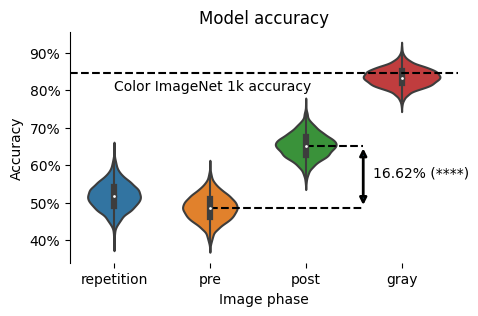

In [14]:
plt.figure(figsize=(5, 3))

# Plot
ax = sns.violinplot(
    data=df,
    x="Image phase",
    y="Accuracy",
    order=["repetition", "pre", "post", "gray"],
)

# Make y label 100 x
plt.yticks(plt.yticks()[0], [f"{int(100 * x)}%" for x in plt.yticks()[0]])

plt.axhline(0.845, color="k", linestyle="--")
plt.annotate("Color ImageNet 1k accuracy", xy=(0, 0.8))

# Draw learning effect
# Line from pre to between post and gray
plt.plot([1, 2.6], [pre_acc.mean(), pre_acc.mean()], "k--")
plt.plot([2, 2.6], [post_acc.mean(), post_acc.mean()], "k--")

# Draw arrow between their means
plt.annotate('', xy=(2.6, pre_acc.mean()), xytext=(2.6, post_acc.mean()),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))

# Find diff
diff = post_acc.mean() - pre_acc.mean()
plt.annotate(f'{100*diff:.2f}% (****)', xy=(2.7, (post_acc.mean() + pre_acc.mean()) / 2))
plt.title("Model accuracy")

plt.gca().spines[['top', 'right', 'bottom']].set_visible(False)

In [11]:
df.groupby(["Image phase"]).mean().reset_index()

,Image phase,synth_seed,model_seed,Time index,Ground truth class,Predicted class,Accuracy
0,gray,499.5,1.5,104.5,499.360952,498.536083,0.835223
1,post,499.5,1.5,104.5,499.360952,497.072893,0.652485
2,pre,499.5,1.5,104.5,499.360952,493.591127,0.486238
3,repetition,499.5,1.5,104.5,499.360952,494.565887,0.517352


In [12]:
0.65 - 0.49

0.16000000000000003